# Estudio correlación variables

En este notebook se llevará a cabo el estudio de la correlación de las señales de la poligrafía nocturna. Para llevar a cabo dicho estudio, es necesario haber ejecutado previamente el programa *calculo_correlacion_retraso_variables.py*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import utils
import os

import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 
plt.rcParams["patch.force_edgecolor"] = True
import utils
%load_ext autoreload
%autoreload 2

## Configuración de variables

En esta sección, se debe indicar la ruta donde se encuentra la información del paciente serializada. De igual forma, se debe indicar el threshold a partir del que realizaremos la división de los pacientes en dos conjuntos, para generar los mapas de correlación en función del nivel de IAH.

In [2]:
# Directorio que contiene los ficheros .csv que se van a analizar
dataset_dir = "../data/pacientes/big-data"
pickle_dir = os.path.join(dataset_dir, "pickle")
threshold = 15

In [3]:
pacientes = []
for f in tqdm(os.listdir(pickle_dir)):
    if os.path.splitext(f)[1] == ".pickle":
        with open(os.path.join(pickle_dir, f), "rb") as handle:
             paciente = pickle.load(handle)
             # Liberamos la memoria porque sino nos quedamos sin RAM
             paciente.clean_memory()
        pacientes.append(paciente)

100%|██████████| 55/55 [00:23<00:00,  2.35it/s]


In [4]:
all_iah_correlation_matrixes = [(paciente.iah, paciente.correlation_matrix) for paciente in pacientes]
all_correlation_matrixes = [correlation_matrix for _, correlation_matrix in all_iah_correlation_matrixes]
higher_apnea_matrix = [corr_matrix for iah, corr_matrix in all_iah_correlation_matrixes if iah >= threshold]
lower_apnea_matrix = [corr_matrix for iah, corr_matrix in all_iah_correlation_matrixes if iah < threshold]

In [5]:
print(f"Número de pacientes con IAH < {threshold}: {len(lower_apnea_matrix)}\nNúmero de pacientes con IAH >= {threshold}: {len(higher_apnea_matrix)}")

Número de pacientes con IAH < 15: 23
Número de pacientes con IAH >= 15: 32


In [6]:
# Extraemos las columnas que contiene las señales
columns = sorted(all_correlation_matrixes[0].columns)

In [9]:
def plot_correlation_matrixes(corr_matrixes, columns, threshold=None, over_threshold=False, savefig=False, figsize=(8, 8)):
    # Realizamos la concatenacion de las matrice de correlacion
    df_concat = pd.concat(corr_matrixes)

    # Calculamos la media y desviacion de dicha concatenacion
    df_concat_mean = df_concat.groupby(level=0).mean()[columns]
    df_concat_std = df_concat.groupby(level=0).std()[columns]
    
    df_concat_mean, df_concat_std = np.round(df_concat_mean, 3), np.round(df_concat_std, 2)

    df_concat_mean.rename(index={"audio_volume_db": "audio_volume"}, columns = {"audio_volume_db": "audio_volume"}, inplace=True)
    df_concat_std.rename(index={"audio_volume_db": "audio_volume"}, columns = {"audio_volume_db": "audio_volume"}, inplace=True)

    # Combinamos el texto, juntando la media y desviacion en una única celda
    text = [f"{str(mean).rstrip('0').rstrip('.')}\n±{str(std).rstrip('0').rstrip('.')}" for mean, std in zip(df_concat_mean.values.flatten(), df_concat_std.values.flatten())]
    text = [i.replace("-0\n", "0\n") if "-0\n" in i else i for i in text]
    formatted_text = (np.asarray(text)).reshape(df_concat_mean.shape)

    # Establecemos el tamaño del mapa de calor
    plt.figure(figsize=figsize)
    
    # Realizamos el grafico
    heatmap = sns.heatmap(df_concat_mean, annot=formatted_text, cmap='coolwarm', fmt="", vmin=-1, vmax=1)

    plt.xticks(rotation=55)
    plt.yticks(rotation=55)
    # heatmap.set_xticklabels(rotation=90)
    # heatmap.set_yticklabels(rotation=270)

    title = 'Mapa de calor correlación '
    if threshold is not None:
        title += f"IAH {'≥' if over_threshold else '<'} {threshold}"
        
    heatmap.set_title(title, pad=12);

    if savefig: plt.savefig(f"{title}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 1)
    
    plt.show()

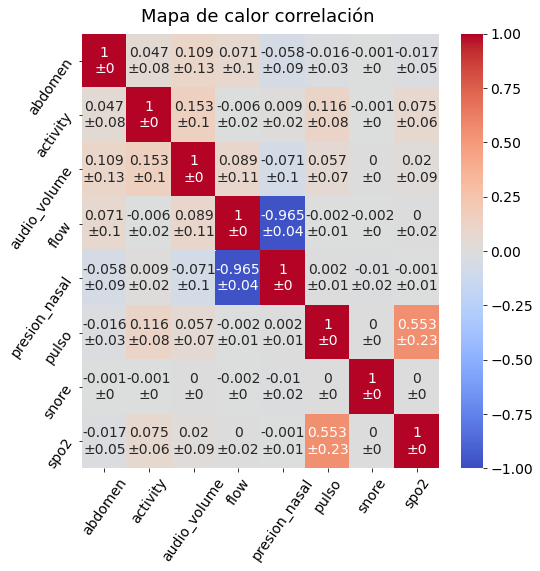

In [10]:
utils.set_font_size(plt, size=14)
#plot_correlation_matrixes(corr_matrixes = all_correlation_matrixes, columns=columns, method="median")
plot_correlation_matrixes(corr_matrixes = all_correlation_matrixes, columns=columns, savefig=False)

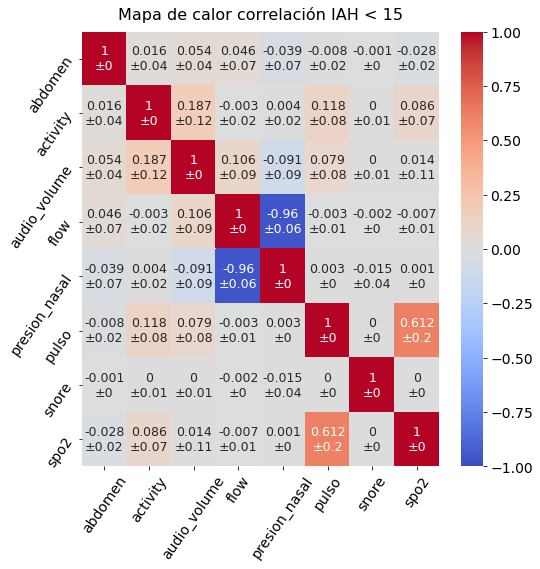

In [11]:
utils.set_font_size(plt, size=12)

size=12
params = {f'legend.fontsize': size,
        f'axes.labelsize':  size,
        f'axes.titlesize': size+4,
        f'xtick.labelsize': 14,
        f'ytick.labelsize': 14,
        f'font.size': 12.5}

plt.rcParams.update(params)

plot_correlation_matrixes(corr_matrixes = lower_apnea_matrix, columns=columns, threshold=threshold, over_threshold=False, figsize=(8, 8), savefig=True)

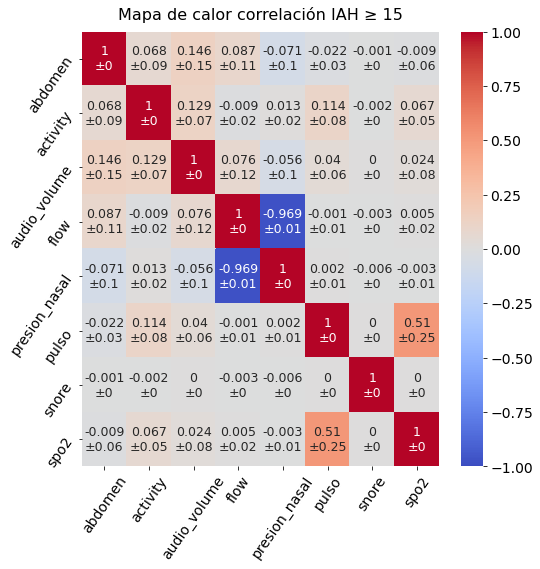

In [12]:
#utils.set_font_size(plt, size=12)
plot_correlation_matrixes(corr_matrixes = higher_apnea_matrix, columns=columns,threshold=threshold, over_threshold=True, figsize=(8, 8), savefig=True)

## Análisis adicional

A la vista de los resultados, parece que en aquellos pacientes con un IAH menor, la correlación con la señal de pulso es mayor. Estudiamos esto en un gráfico adicional

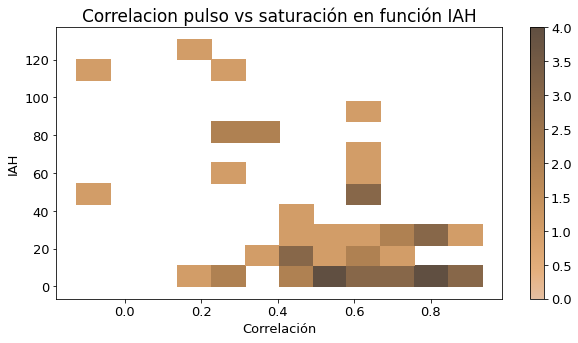

In [13]:
plt.figure(figsize=(10, 5))
utils.set_font_size(plt, size=13)
correlation_spo2_pulso = [(paciente.iah, paciente.correlation_matrix["spo2"]["pulso"]) for paciente in pacientes]
correlation_spo2_pulso_df = pd.DataFrame(correlation_spo2_pulso, columns=["IAH", "Corr"])
sns.histplot(correlation_spo2_pulso_df,y="IAH", x="Corr", bins=12, shrink=1, cbar=True)
plt.xlabel("Correlación")
plt.ylabel("IAH")
plt.title("Correlacion pulso vs saturación en función IAH")
plt.savefig("correlacion_pulso_vs_saturacion_IAH.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)
plt.show()

Podemos observar como aparentemente, la correlación es menor en aquellos pacientes con un IAH mayor. Queremos cuantificar esto numéricamente. En particular, estableciendo la barrera de IAH en 30, vamos a ver cuántos pacientes tienen una correlación > 0.4 y cuantos < 0.4

In [57]:
threshold = 30
correlation_limit=0.4
all_iah_correlation_matrixes = [(paciente.iah, paciente.correlation_matrix) for paciente in pacientes]
all_correlation_matrixes = [correlation_matrix for _, correlation_matrix in all_iah_correlation_matrixes]
higher_apnea_corr = np.array([corr_matrix["pulso"]["spo2"] for iah, corr_matrix in all_iah_correlation_matrixes if iah >= threshold])
lower_apnea_corr = np.array([corr_matrix["pulso"]["spo2"] for iah, corr_matrix in all_iah_correlation_matrixes if iah < threshold])

In [58]:
print (f"De los {len(lower_apnea_corr)} pacientes con IAH < {threshold}, el {np.mean(lower_apnea_corr > 0.4):.2f}% tienen una correlación>{correlation_limit}")
print (f"De los {len(higher_apnea_corr)} pacientes con IAH > {threshold}, el {np.mean(higher_apnea_corr < 0.4):.2f}% tienen una correlación<{correlation_limit}")

De los 38 pacientes con IAH < 30, el 0.89% tienen una correlación>0.4
De los 17 pacientes con IAH > 30, el 0.47% tienen una correlación<0.4
